Here Wheeler-Hendon phase diagram for Jun-Sep 2013 –from OLR, U850 & U200 – RMM indices -  From first two PCAs of FULL STACK MATRIX is plotted

NOTE: THis is the standard representation of the MJO is we are using OLR along with other variables
It is will provided only single value for each day. It wont create any spatial representation

Actually there is no spatial representation for MJO if we are using more variable


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA


In [2]:

# Load datasets

olr = xr.open_dataset("olr.nc")['olr']
u850 = xr.open_dataset("u850.nc")['u']
u200 = xr.open_dataset("u200.nc")['u']


# Rename time dimension if necessary

if 'valid_time' in olr.dims:
    olr = olr.rename({'valid_time':'time'})
if 'valid_time' in u850.dims:
    u850 = u850.rename({'valid_time':'time'})
if 'valid_time' in u200.dims:
    u200 = u200.rename({'valid_time':'time'})


# Equatorial band selection

lat_min, lat_max = -10, 10
def select_equator(ds, lat_min=-10, lat_max=10):
    # Handles descending or ascending latitudes
    lat0, lat1 = sorted([lat_min, lat_max])
    return ds.sel(lat=slice(lat1, lat0))

olr_eq = select_equator(olr, lat_min, lat_max)
u850_eq = select_equator(u850, lat_min, lat_max)
u200_eq = select_equator(u200, lat_min, lat_max)


# Normalize (z-score) along time

def normalize(ds):
    mean = ds.mean(dim='time')
    std = ds.std(dim='time')
    return (ds - mean) / std

olr_norm = normalize(olr_eq)
u850_norm = normalize(u850_eq)
u200_norm = normalize(u200_eq)


# Bandpass filter for MJO (OLR only)

low_period = 30    # days
high_period = 90   # days
fs = 1             # daily data
order = 4

def bandpass_filter(data, low_period, high_period, fs=1, order=4):
    nyq = 0.5 * fs
    low = 1.0 / high_period / nyq
    high = 1.0 / low_period / nyq
    b, a = butter(order, [low, high], btype='band')

    def _filter_1d(x):
        return filtfilt(b, a, x, axis=0)

    filtered = xr.apply_ufunc(
        _filter_1d, data,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[data.dtype]
    )
    return filtered

olr_mjo = bandpass_filter(olr_norm, low_period, high_period)


# Flatten lat-lon into features

def flatten_space(ds):
    # ds can have additional dimensions like 'pressure_level'
    spatial_dims = [d for d in ds.dims if d != 'time']
    return ds.stack(features=spatial_dims).transpose('time', 'features').values

olr_flat = flatten_space(olr_mjo)     # filtered OLR
u850_flat = flatten_space(u850_norm)   # normalized u850
u200_flat = flatten_space(u200_norm)   # normalized u200

# Combine into single matrix: [time, features]
X = np.hstack([olr_flat, u850_flat, u200_flat])
print("Shape of combined matrix X:", X.shape)  # (time, total_features)


# PCA for RMM calculation

pca = PCA(n_components=2)
RMM = pca.fit_transform(X)  # shape: (time, 2)

RMM1 = RMM[:, 0]
RMM2 = RMM[:, 1]

print("RMM1 shape:", RMM1.shape)
print("RMM2 shape:", RMM2.shape)


Shape of combined matrix X: (1461, 3888)
RMM1 shape: (1461,)
RMM2 shape: (1461,)


In [3]:
# check for NaNs and shapes
print("olr_mjo shape:", olr_mjo.shape)
print("u850_norm shape:", u850_norm.shape)
print("u200_norm shape:", u200_norm.shape)

print("Any NaNs? olr:", np.isnan(olr_flat).any(), "u850:", np.isnan(u850_flat).any(), "u200:", np.isnan(u200_flat).any())

# feature variance statistics (after flatten)
feat_var = X.var(axis=0)
print("feature var: min, median, max =", feat_var.min(), np.median(feat_var), feat_var.max())

# PCA component std (before any scaling)
print("PC std before scaling:", RMM.std(axis=0))


olr_mjo shape: (9, 144, 1461)
u850_norm shape: (1461, 1, 9, 144)
u200_norm shape: (1461, 1, 9, 144)
Any NaNs? olr: False u850: False u200: False
feature var: min, median, max = 0.017826764 0.9999995 1.0000029
PC std before scaling: [24.712    13.979236]


In [4]:
# After computing X and pca.fit_transform(X)
PCs = pca.fit_transform(X)  # shape (time, 2)

# scale each PC to have unit std (over the full period or a reference climatology)
PCs[:,0] /= PCs[:,0].std()
PCs[:,1] /= PCs[:,1].std()

RMM1 = PCs[:,0]
RMM2 = PCs[:,1]
RMM_amp = np.sqrt(RMM1**2 + RMM2**2)


In [5]:
#check per-field ranges
print("olr_mjo range:", np.nanmin(olr_flat), np.nanmax(olr_flat))
print("u850 range:", np.nanmin(u850_flat), np.nanmax(u850_flat))
print("u200 range:", np.nanmin(u200_flat), np.nanmax(u200_flat))


olr_mjo range: -2.9569178 4.3193583
u850 range: -6.828099 7.87885
u200 range: -4.4676356 4.977099


In [6]:


#  Combine all variables for PCA

X = np.hstack([olr_flat, u850_flat, u200_flat])
print("Combined data matrix shape:", X.shape)

# Remove any NaNs if present
X = np.nan_to_num(X)


# Principal Component Analysis (RMM)

pca = PCA(n_components=2)
RMM = pca.fit_transform(X)

# Scale RMMs to unit standard deviation
RMM1 = RMM[:, 0] / np.std(RMM[:, 0])
RMM2 = RMM[:, 1] / np.std(RMM[:, 1])

print("RMM1 std:", np.std(RMM1))
print("RMM2 std:", np.std(RMM2))


# RMM amplitude and phase

amp = np.sqrt(RMM1**2 + RMM2**2)
phase = np.arctan2(RMM2, RMM1) * 180 / np.pi


# Save to file or inspect
# ============================================================
rmm_ds = xr.Dataset(
    {
        "RMM1": (("time",), RMM1),
        "RMM2": (("time",), RMM2),
        "amplitude": (("time",), amp),
        "phase": (("time",), phase),
    },
    coords={"time": olr_eq.time}
)

#rmm_ds.to_netcdf("rmm_indices.nc")


Combined data matrix shape: (1461, 3888)
RMM1 std: 1.0
RMM2 std: 1.0


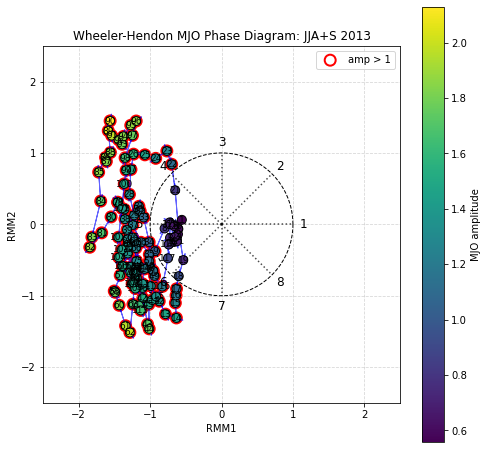

In [7]:
time = pd.to_datetime(rmm_ds.time.values)
time = pd.to_datetime(time)
mask = (time >= '2013-06-01') & (time <= '2013-09-30')
RMM1_sel = RMM1[mask]
RMM2_sel = RMM2[mask]
time_sel = time[mask]

amp_sel = np.sqrt(RMM1_sel**2 + RMM2_sel**2)


# Wheeler-Hendon plot with arrows

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

# Unit circle
theta = np.linspace(0, 2*np.pi, 200)
ax.plot(np.cos(theta), np.sin(theta), 'k--', lw=1)

# 8-phase lines
for angle in np.linspace(0, 2*np.pi, 8, endpoint=False):
    ax.plot([0, np.cos(angle)], [0, np.sin(angle)], 'k:', alpha=0.7)

# Trajectory arrows
for i in range(len(RMM1_sel)-1):
    ax.arrow(RMM1_sel[i], RMM2_sel[i], 
             RMM1_sel[i+1]-RMM1_sel[i], RMM2_sel[i+1]-RMM2_sel[i],
             head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.6)

# Scatter points colored by amplitude
sc = ax.scatter(RMM1_sel, RMM2_sel, c=amp_sel, cmap='viridis', s=80, edgecolors='k', zorder=3)
cbar = plt.colorbar(sc, ax=ax, label='MJO amplitude')

# Highlight points outside unit circle
outside = amp_sel > 1
ax.scatter(RMM1_sel[outside], RMM2_sel[outside], facecolors='none', edgecolors='red', s=120, lw=2, label='amp > 1')

# Number the points
for i, (x, y) in enumerate(zip(RMM1_sel, RMM2_sel)):
    ax.text(x, y, str(i+1), fontsize=9, ha='center', va='center')

# Phases around the circle
phases = ['1','2','3','4','5','6','7','8']
for i, angle in enumerate(np.linspace(0, 2*np.pi, 8, endpoint=False)):
    ax.text(1.15*np.cos(angle), 1.15*np.sin(angle), phases[i], fontsize=12, ha='center', va='center')

# Axes, labels, title
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_xlabel('RMM1')
ax.set_ylabel('RMM2')
ax.set_title('Wheeler-Hendon MJO Phase Diagram: JJA+S 2013')

ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
plt.savefig("Figure11.jpg", format="jpg", dpi=300)
plt.show()
